Сравнение результатов всех моделей и бейзлайна

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
KNN = KNeighborsRegressor
from sklearn import linear_model
lm = linear_model
import sys
sys.path.append('../data proccessing/')
from api_util import get_near_metro
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [156]:
SIZE_CUT_VALUE = 700
PRICE_CUT_VALUE = 4500

df_train = pd.read_csv('../datasets/data_with_classes_and_metros.csv')
df_train = df_train[(df_train.price < PRICE_CUT_VALUE) &
                    (df_train['size'] < SIZE_CUT_VALUE)]

df_test = pd.read_csv('../datasets/result_test.csv')
df_test = df_test[(df_test.price < PRICE_CUT_VALUE) &
                    (df_test['size'] < SIZE_CUT_VALUE)]

df_train.drop(['Unnamed: 0'], inplace=True, axis=1)
print(df_train.head(5))

    size class  price  pledge  near_metro  parking  internet  meal  security  \
0   28.8     b   1354   39000       700.0        0         0     0         0   
1  588.2     b    850  500000       700.0        1         0     0         0   
2   45.0     b   1111   50000       200.0        1         0     0         1   
3  100.0     b   1700  170000       700.0        1         0     0         1   
4  190.0     c    789  150000      1200.0        0         1     0         0   

   comfort        lat        lon  distance  
0        1  55.745093  37.664815   0.09581  
1        1  55.745093  37.664815   0.09581  
2        0  55.759659  37.752850   0.27184  
3        0  55.569026  37.588647   0.19060  
4        0  55.757496  37.802086   0.37023  


In [157]:
df_test.drop(['Unnamed: 0', 'address', 'descr', 'url', 'metros'], inplace=True, axis=1)
print(df_test.head(5))

   size class  price  pledge  near_metro  parking  internet  meal  security  \
1   8.0     a   1250   10000       300.0        0         1     0         0   
2  20.0     b   1450   29000       600.0        0         1     0         0   
3  34.5     b   1043   36000       600.0        1         0     1         1   
4  15.0   NaN   2667   40000       300.0        0         1     1         1   
5  39.7   NaN   1700   67490       200.0        0         1     1         1   

   comfort        lat        lon  distance  
1        4  55.747115  37.539078   0.15589  
2        3  55.740466  37.521471   0.19135  
3        0  55.830695  37.431010   0.38042  
4        5  55.758174  37.634290   0.03532  
5        4  55.743320  37.650523   0.06748  


# Nan-ы в ближайшем метро

In [158]:
# пока что просто их выкину, все равно больше 900 знаечний осталось
# df_test.dropna(subset=['class', 'near_metro'], inplace=True)
null_metro = df_test[df_test['near_metro'].isnull()]

In [124]:
df_test.shape

(1490, 13)

In [125]:
with open('../apies/yandex_organization_search_api.txt') as f:
    apikey = f.readline()

In [126]:
for index, row in null_metro.iterrows():
    null_metro.at[index, 'near_metro'] = get_near_metro(row['lon'], row['lat'], apikey)

In [127]:
df_test[df_test['near_metro'].isnull()] = null_metro

# Nan-ы в классах

In [118]:
def fill_class_Nans(df):
    null_classes = df[df['class'].isnull()].drop(['price'], axis=1)
    not_null_classes = df[~df['class'].isnull()].drop(['price'], axis=1)
    ohe_features = ['parking', 'internet', 'meal', 'security']
    X_data = not_null_classes.drop(['class'], axis=1)
    X_data.drop(ohe_features, axis=1, inplace=True)
    y_data = not_null_classes['class'].copy()
    scaler = StandardScaler()
    X_data = scaler.fit_transform(X_data)
    for feature in ohe_features:
        X_data = np.append(X_data, np.array([not_null_classes[feature]]).T, axis=1)
    clf = KNeighborsClassifier()
    scores = cross_val_score(clf, X_data, y_data, cv=5)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    clf.fit(X_data, y_data)
    Target_data = null_classes.drop(['class'], axis=1)
    Target_data.drop(ohe_features, axis=1, inplace=True)
    Target_data = pd.DataFrame(scaler.transform(Target_data))
    for feature in ohe_features:
        Target_data = np.append(Target_data, np.array([null_classes[feature]]).T, axis=1)
    classes = clf.predict(Target_data)
    df.loc[df['class'].isnull(), 'class'] = classes

In [129]:
fill_class_Nans(df_test)

[ 0.7032967   0.66850829  0.65        0.74301676  0.68715084]
Accuracy: 0.69 (+/- 0.06)


In [132]:
df_test.to_csv('test_data_with_metro_classes.csv')

In [174]:
df_test = pd.read_csv('test_data_with_metro_classes.csv')
df_test.drop(['Unnamed: 0'], inplace=True, axis=1)
df_test.head(5)

,size,class,price,pledge,near_metro,parking,internet,meal,security,comfort,lat,lon,distance
0,8.0,a,1250,10000,300.0,0,1,0,0,4,55.747115,37.539078,0.15589
1,20.0,b,1450,29000,600.0,0,1,0,0,3,55.740466,37.521471,0.19135
2,34.5,b,1043,36000,600.0,1,0,1,1,0,55.830695,37.431010,0.38042
3,15.0,b,2667,40000,300.0,0,1,1,1,5,55.758174,37.634290,0.03532
4,39.7,b,1700,67490,200.0,0,1,1,1,4,55.743320,37.650523,0.06748


# Train Test Split

In [175]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_train['class'] = le.fit_transform(df_train['class'])
df_test['class'] = le.fit_transform(df_test['class'])

In [176]:
X_train = df_train.drop(['price'], axis=1)
y_train = df_train['price'].copy()

In [177]:
X_test = df_test.drop(['price'], axis=1)
y_test = df_test['price'].copy()

## Baseline

In [178]:
def base_line_predict(X_test, X_train, y_train, numeric_class = False):
    """
    Возвращает среднюю классу цену 
    """
    if numeric_class == True:
        a_mean = y_train.loc[X_train[X_train['class'] == 0].index].mean()
        b_mean = y_train.loc[X_train[X_train['class'] == 1].index].mean()
        c_mean = y_train.loc[X_train[X_train['class'] == 2].index].mean()
        d_mean = y_train.loc[X_train[X_train['class'] == 3].index].mean()
    else:
        a_mean = y_train.loc[X_train[X_train['class'] == 'a'].index].mean()
        b_mean = y_train.loc[X_train[X_train['class'] == 'b'].index].mean()
        c_mean = y_train.loc[X_train[X_train['class'] == 'c'].index].mean()
        d_mean = y_train.loc[X_train[X_train['class'] == 'd'].index].mean()
    y_pred = pd.Series(index = X_test.index)
    if numeric_class == True:
        y_pred.loc[X_test[X_test['class'] == 0].index] = a_mean
        y_pred.loc[X_test[X_test['class'] == 1].index] = b_mean
        y_pred.loc[X_test[X_test['class'] == 2].index] = c_mean
        y_pred.loc[X_test[X_test['class'] == 3].index] = d_mean
    else:
        y_pred.loc[X_test[X_test['class'] == 'a'].index] = a_mean
        y_pred.loc[X_test[X_test['class'] == 'b'].index] = b_mean
        y_pred.loc[X_test[X_test['class'] == 'c'].index] = c_mean
        y_pred.loc[X_test[X_test['class'] == 'd'].index] = d_mean
    return y_pred

In [179]:
bs_pred = base_line_predict(X_test=X_test, X_train=X_train,
                                     y_train=y_train, numeric_class=True)

print("baseline is {:5.1f}".format(np.sqrt(mse(y_true=y_test, y_pred=bs_pred))))

baseline is 614.5


## Несколько моделей с деревьями

Лучшее значение равно 527.9 при глубине дерева равной 6.


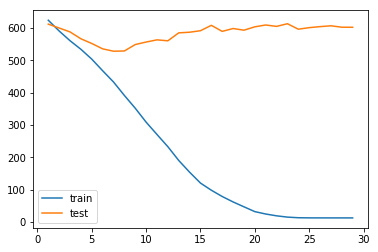

In [180]:
trees = range(1, 30)

train = []
test = []

for tree in trees:
    clf = DecisionTreeRegressor(max_depth=tree, random_state=12345)
    clf.fit(X_train, y_train)
    
    train.append(np.sqrt(mse(y_true=y_train, y_pred=clf.predict(X_train))))
    test.append(np.sqrt(mse(y_true=y_test, y_pred=clf.predict(X_test))))

plt.plot(trees, train, label='train')
plt.plot(trees, test, label='test')
plt.legend()
plt.show

print("Лучшее значение равно {:5.1f} при глубине дерева равной {}.".format(min(test), test.index(min(test))))

# Случайный лес (см. Trees.ipynb)

In [181]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42, 
                            n_jobs=-1, oob_score=True, max_depth=20,
                            min_samples_leaf=1, max_features=11)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=11, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [182]:
rfr.oob_score_

0.65757244316075425

In [183]:
print("random forest mse:" ,np.sqrt(mse(y_true=y_test, y_pred=rfr.predict(X_test))))

random forest mse: 417.216269505


## KNN

In [184]:
ohe_features = ['parking', 'internet', 'meal', 'security']

In [185]:
X_train = df_train.drop(['price'], axis=1)
X_train.drop(ohe_features, axis=1, inplace=True)
y_train = df_train['price'].copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
for feature in ohe_features:
    X_train = np.append(X_train, np.array([df_train[feature]]).T, axis=1)

In [186]:
X_test = df_test.drop(['price'], axis=1)
X_test.drop(ohe_features, axis=1, inplace=True)
y_test = df_test['price'].copy()
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
for feature in ohe_features:
    X_test = np.append(X_test, np.array([df_test[feature]]).T, axis=1)

In [187]:
n_neighb = range(1, 100, 10)

for n in n_neighb:
    clf = KNN(n_neighbors=n, weights='distance')
    clf.fit(X_train, y_train)
    print("KNN n_neighbors={} {:5.1f}".format(n, np.sqrt(mse(y_true=y_test, y_pred=clf.predict(X_test)))))

KNN n_neighbors=1 710.5
KNN n_neighbors=11 546.5
KNN n_neighbors=21 542.6
KNN n_neighbors=31 541.5
KNN n_neighbors=41 545.2
KNN n_neighbors=51 547.9
KNN n_neighbors=61 550.6
KNN n_neighbors=71 552.1
KNN n_neighbors=81 553.1
KNN n_neighbors=91 555.6


Возле 10 соседей походим поподробнее

In [188]:
n_neighb = range(1, 20)
knn_res = []

for n in n_neighb:
    clf = KNN(n_neighbors=n, weights='distance')
    clf.fit(X_train, y_train)
    knn_res.append(np.sqrt(mse(y_true=y_test, y_pred=clf.predict(X_test))))
    
print("Лучшее значение равно {:5.1f} при числе соседей равном {}.".format(min(knn_res), knn_res.index(min(knn_res))))

Лучшее значение равно 543.8 при числе соседей равном 18.


## Линейная регрессия

In [189]:
clf = lm.LinearRegression()
clf.fit(X_train, y_train)
print("Линейная регрессия {:5.1f}".format(np.sqrt(mse(y_true=y_test, y_pred=clf.predict(X_test)))))

Линейная регрессия 638.1


In [190]:
clf = lm.Ridge(alpha=.5)
clf.fit(X_train, y_train)
print("Ridge {:5.1f}".format(np.sqrt(mse(y_true=y_test, y_pred=clf.predict(X_test)))))

Ridge 638.1


In [191]:
clf = lm.Lasso(alpha=.1)
clf.fit(X_train, y_train)
print("Lasso {:5.1f}".format(np.sqrt(mse(y_true=y_test, y_pred=clf.predict(X_test)))))

Lasso 638.0
